# Détection d'Objets en Temps Réel avec YOLOv5 : Reconnaissance de Gestes de la Main

### Analyse de l'Ensemble de Données

In [3]:
import pandas as pd

path_annotation_train = "rock-paper-scissors/train/train/_annotations.csv"

df_annotation_train = pd.read_csv(path_annotation_train)
df_annotation_train

filename  width  height  \
0     egohands-public-1620914960773_png_jpg.rf.aa184...    640     640   
1     egohands-public-1624053434391_png_jpg.rf.aaef5...    640     640   
2     egohands-public-1624465902684_png_jpg.rf.aaa09...    640     640   
3     Screen-Shot-2022-02-08-at-12-59-24-PM_png.rf.a...    640     640   
4     egohands-public-1622127402076_png_jpg.rf.aa897...    640     640   
...                                                 ...    ...     ...   
4605  youtube-110_jpg.rf.617bbb713bb7283ec31ef55bc8c...    640     640   
4606  20220216_222247_jpg.rf.619399ee585a03994872dc3...    640     640   
4607  IMG_7043_MOV-93_jpg.rf.615ac5e9bc512fcc26af997...    640     640   
4608  egohands-public-1620849831752_png_jpg.rf.61844...    640     640   
4609  egohands-public-1624546380201_png_jpg.rf.61942...    640     640   

         class  xmin  ymin  xmax  ymax  
0         Rock   429   185   562   319  
1        Paper   269   354   544   443  
2         Rock   427   332   551   509  
3         Rock    80   268   145   395  
4         Rock    83   128   296   381  
...        ...   ...   ...   ...   ...  
4605      Rock    67   149   218   389  
4606     Paper   107   292   453   466  
4607      Rock   237   363   555   535  
4608  Scissors   406   216   608   592  
4609      Rock   242   332   391   485  

[4610 rows x 8 columns]

| Colonne                        | Description                                                   |
| ------------------------------ | ------------------------------------------------------------- |
| `filename`                     | Nom du fichier image (ex : `egohands-public-...jpg`)          |
| `width`                        | Largeur de l’image (en pixels) — ici toujours 640             |
| `height`                       | Hauteur de l’image (en pixels) — ici toujours 640             |
| `class`                        | Classe de l’objet annoté (Rock, Paper, Scissors)              |
| `xmin`, `ymin`, `xmax`, `ymax` | Coordonnées du rectangle englobant (`bounding box`) en pixels |


In [6]:
print(df_annotation_train['class'].value_counts())  # répartition des classes
print(df_annotation_train.isnull().sum())      # vérifier les valeurs manquantes

class
Rock        1924
Paper       1349
Scissors    1337
Name: count, dtype: int64
filename    0
width       0
height      0
class       0
xmin        0
ymin        0
xmax        0
ymax        0
dtype: int64


### Visualisation d'une image + bounding bow

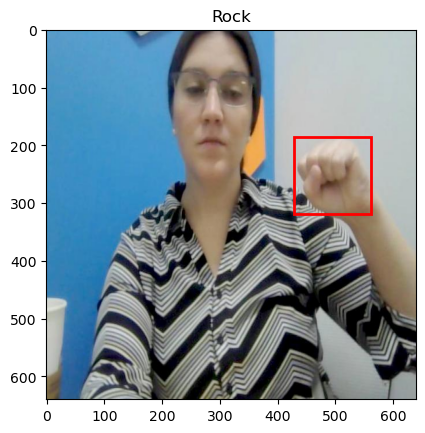

In [8]:
import matplotlib.pyplot as plt
import cv2

# Exemple : afficher la première image annotée
image_path = f"rock-paper-scissors/train/train/{df_annotation_train.loc[0, 'filename']}"
img = cv2.imread(image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Bounding box
x1, y1 = df_annotation_train.loc[0, 'xmin'], df_annotation_train.loc[0, 'ymin']
x2, y2 = df_annotation_train.loc[0, 'xmax'], df_annotation_train.loc[0, 'ymax']

plt.imshow(img)
plt.gca().add_patch(plt.Rectangle((x1, y1), x2 - x1, y2 - y1, 
                                  edgecolor='red', facecolor='none', linewidth=2))
plt.title(df_annotation_train.loc[0, 'class'])
plt.show()

### Préparation des labels au format normalisé YOLO

In [10]:
import os
classes = sorted(df_annotation_train['class'].unique().tolist())
os.makedirs("working/train/labels", exist_ok=True)

def convert_yolo_format(row):
    class_id = classes.index(row['class'])
    x_center = (row['xmin'] + row['xmax']) / 2 / row['width']
    y_center = (row['ymin'] + row['ymax']) / 2 / row['height']
    bbox_width = (row['xmax'] - row['xmin']) / row['width']
    bbox_height = (row['ymax'] - row['ymin']) / row['height']
    return f"{class_id} {x_center:.6f} {y_center:.6f} {bbox_width:.6f} {bbox_height:.6f}"

for filename, group in df_annotation_train.groupby('filename'):
    yolo_labels = group.apply(convert_yolo_format, axis=1)
    from pathlib import Path
    label_path = f"working/train/labels/{Path(filename).stem}.txt"
    with open(label_path, "w") as f:
        f.write("\n".join(yolo_labels) + "\n")

### Structuration du dossier d'entraînement

In [12]:
import shutil

src_dir = "rock-paper-scissors/train/train"
dst_dir = "working/train/images"

os.makedirs(dst_dir, exist_ok=True)

# Copier toutes les images (jpg, png...) du dossier source vers destination
for filename in os.listdir(src_dir):
    if filename.lower().endswith((".jpg", ".jpeg", ".png")):
        shutil.copy(os.path.join(src_dir, filename), os.path.join(dst_dir, filename))

print(f"Copié {len(os.listdir(dst_dir))} images dans {dst_dir}")

Copié 6455 images dans working/train/images


### Création du fichier de configuration (YAML)

In [15]:
yaml_content = """
train: working/train/images
val: working/train/images

nc: 3
names: ['Paper', 'Rock', 'Scissors']
"""

with open("data.yaml", "w") as f:
    f.write(yaml_content)


print("Fichier data.yaml créé !")

Fichier data.yaml créé !


In [17]:
labels_path = "working/train/labels"
txt_files = [f for f in os.listdir(labels_path) if f.endswith(".txt")]

### Entraînement du Modèle (Training)

In [19]:
from ultralytics import YOLO

# Charger un modèle pré-entraîné (YOLOv5 small)
model = YOLO("yolov5su.pt")

# Lancer l'entraînement en utilisant le fichier de config data.yaml
model.train(data="data.yaml", epochs=5, imgsz=640)

Ultralytics 8.3.228  Python-3.12.7 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce MX150, 2048MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov5su.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretr

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x000001C50CB9EE40>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          

### Test du modèle sur de nouvelles images

In [21]:
from glob import glob
# Dossier contenant les images de test
test_dir = 'rock-paper-scissors/test/test'
image_paths = sorted(glob(os.path.join(test_dir, '*.jpg')))


image 1/1 C:\Users\omar\MLAIM_25\project_yolo\rock-paper-scissors\test\test\10e0gvm_jpg.rf.3b68a834fab647f30a57fc3ea92d4cd2.jpg: 640x640 (no detections), 558.6ms
Speed: 5.6ms preprocess, 558.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


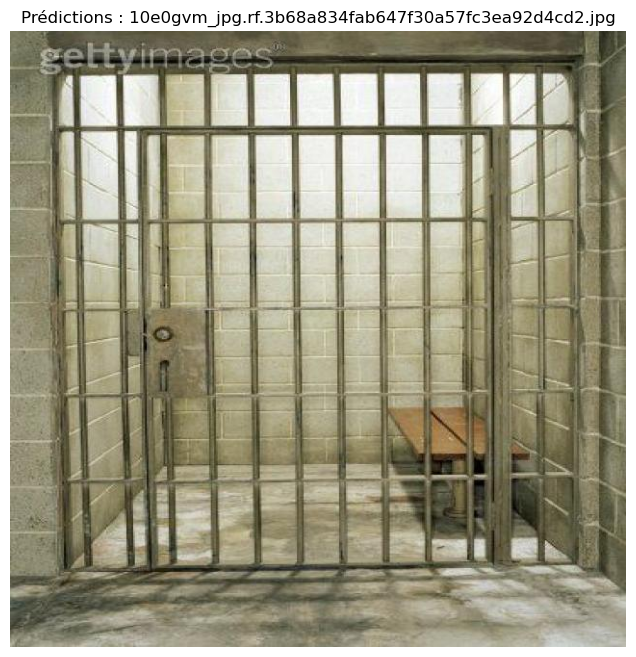


image 1/1 C:\Users\omar\MLAIM_25\project_yolo\rock-paper-scissors\test\test\15208484cellblock_jpg.rf.95cbda1e169a66105fbf2aa22959a73b.jpg: 640x640 (no detections), 423.8ms
Speed: 4.8ms preprocess, 423.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


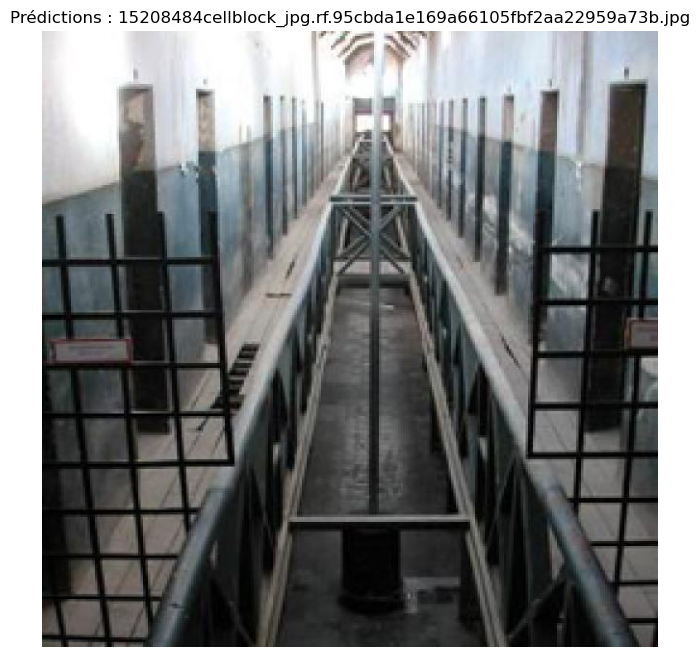


image 1/1 C:\Users\omar\MLAIM_25\project_yolo\rock-paper-scissors\test\test\19171_298_298_1_0_jpg.rf.0024dfb25d7b5a13a78e94fca47ef004.jpg: 640x640 (no detections), 520.4ms
Speed: 4.3ms preprocess, 520.4ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


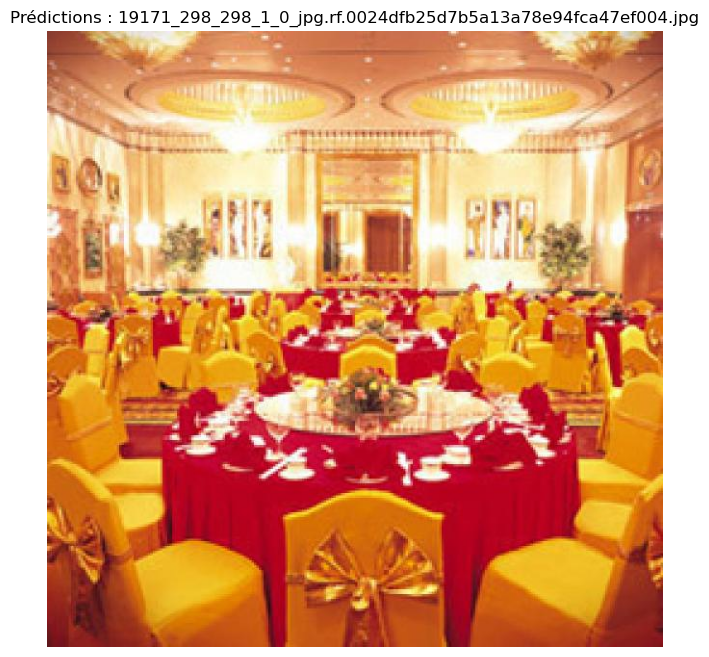


image 1/1 C:\Users\omar\MLAIM_25\project_yolo\rock-paper-scissors\test\test\20061004021831_jpg.rf.8667d8aa5599deb901289c024eed4313.jpg: 640x640 (no detections), 640.4ms
Speed: 5.5ms preprocess, 640.4ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)


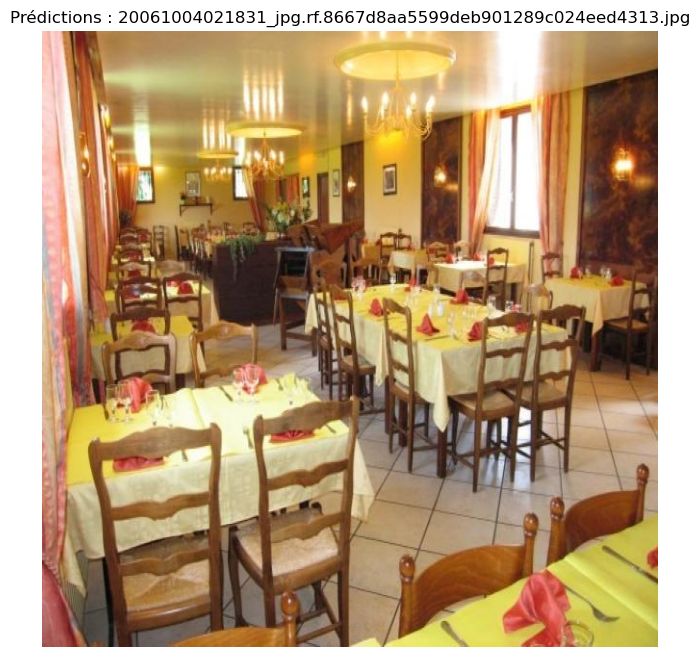


image 1/1 C:\Users\omar\MLAIM_25\project_yolo\rock-paper-scissors\test\test\20220216_221550_jpg.rf.02a071a383151953fcf8671fc7fca3af.jpg: 640x640 1 Scissors, 713.2ms
Speed: 10.8ms preprocess, 713.2ms inference, 20.0ms postprocess per image at shape (1, 3, 640, 640)


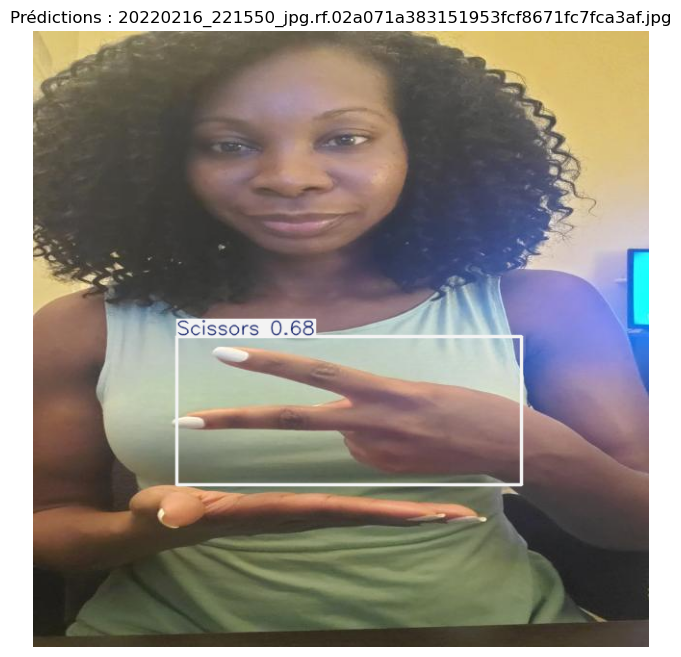


image 1/1 C:\Users\omar\MLAIM_25\project_yolo\rock-paper-scissors\test\test\20220216_221819_jpg.rf.295ebb583293f91f74e1700f0ab0639a.jpg: 640x640 1 Rock, 667.4ms
Speed: 8.8ms preprocess, 667.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


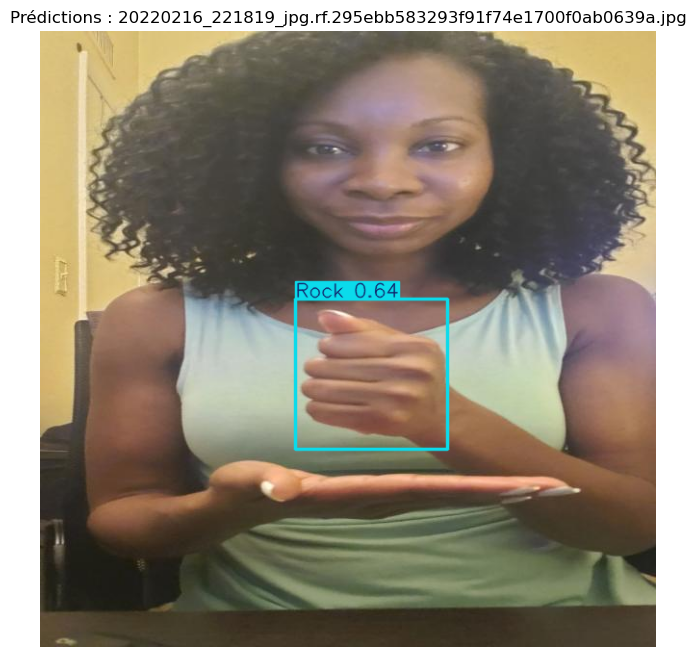


image 1/1 C:\Users\omar\MLAIM_25\project_yolo\rock-paper-scissors\test\test\20220216_221856_jpg.rf.c551cb3856f480cba36d6aa58e3300cd.jpg: 640x640 1 Rock, 636.7ms
Speed: 6.1ms preprocess, 636.7ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 640)


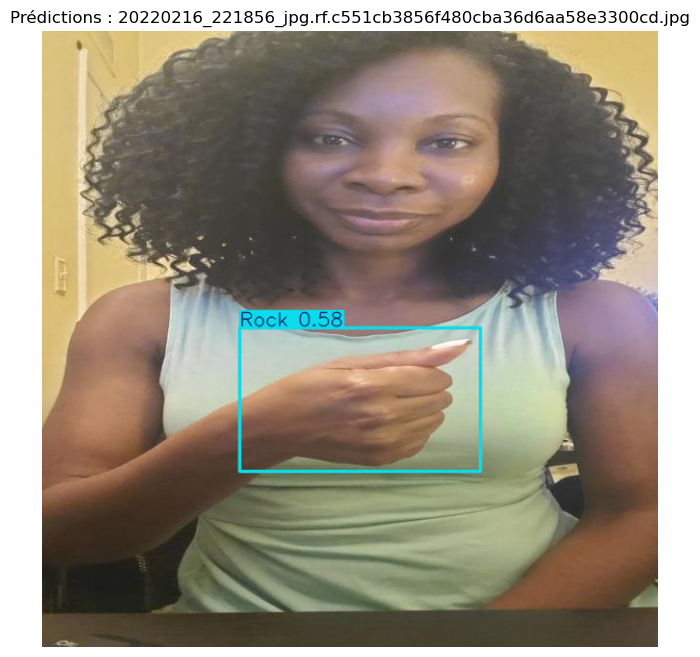


image 1/1 C:\Users\omar\MLAIM_25\project_yolo\rock-paper-scissors\test\test\20220216_222153_jpg.rf.a2bd5f6dd7833d67c9cb2e1d9ca298cc.jpg: 640x640 1 Paper, 1 Scissors, 683.4ms
Speed: 9.9ms preprocess, 683.4ms inference, 9.5ms postprocess per image at shape (1, 3, 640, 640)


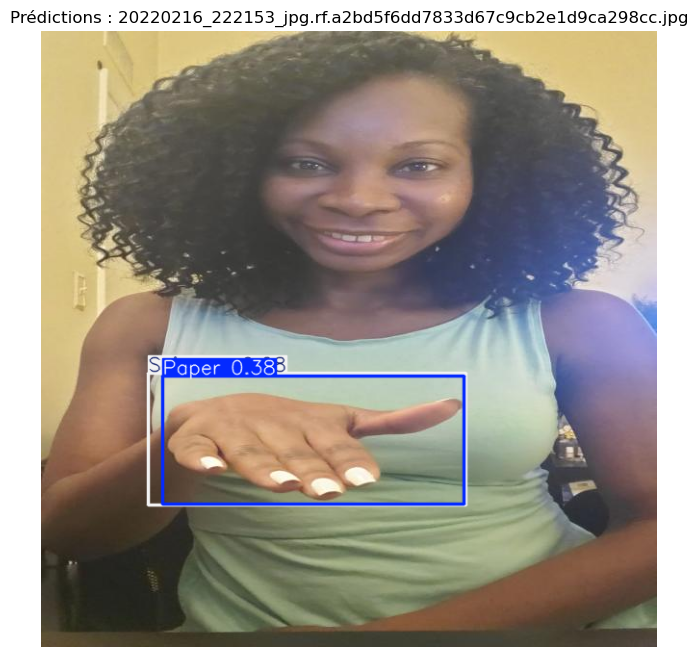


image 1/1 C:\Users\omar\MLAIM_25\project_yolo\rock-paper-scissors\test\test\20220216_222607_jpg.rf.2d3554cdf3b954df7e481bf1b22a1e47.jpg: 640x640 1 Rock, 600.2ms
Speed: 9.2ms preprocess, 600.2ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)


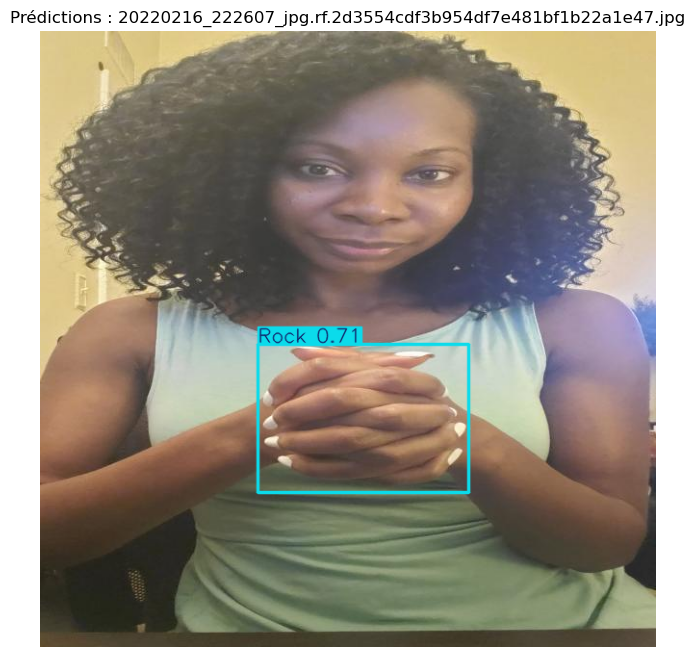


image 1/1 C:\Users\omar\MLAIM_25\project_yolo\rock-paper-scissors\test\test\CARDS_LIVINGROOM_B_T_frame_0124_jpg.rf.9950e0cf7efb81973a65899429e2d42c.jpg: 640x640 (no detections), 588.2ms
Speed: 8.8ms preprocess, 588.2ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)


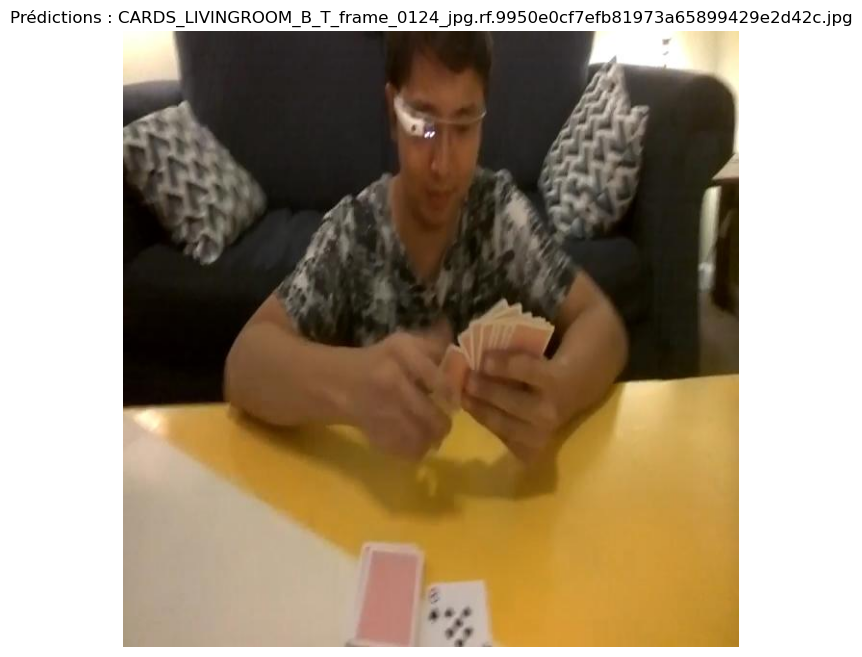


image 1/1 C:\Users\omar\MLAIM_25\project_yolo\rock-paper-scissors\test\test\CARDS_OFFICE_S_B_frame_0057_jpg.rf.63d2ab9abbc8a04ca7731f44722ef94e.jpg: 640x640 (no detections), 384.2ms
Speed: 31.0ms preprocess, 384.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


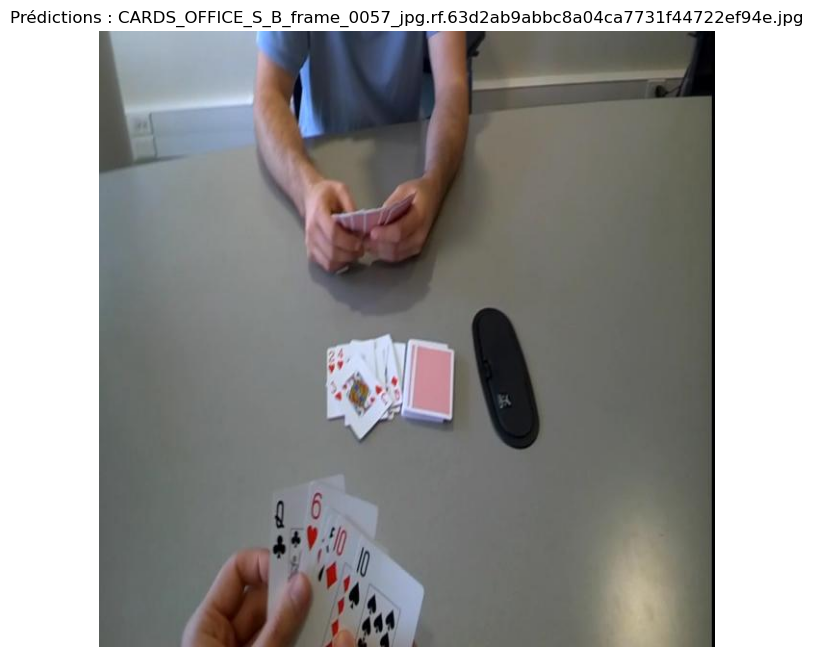


image 1/1 C:\Users\omar\MLAIM_25\project_yolo\rock-paper-scissors\test\test\CARDS_OFFICE_T_H_frame_0223_jpg.rf.3a4ae068939baaf6572c3ef4b88b4969.jpg: 640x640 (no detections), 223.1ms
Speed: 18.4ms preprocess, 223.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


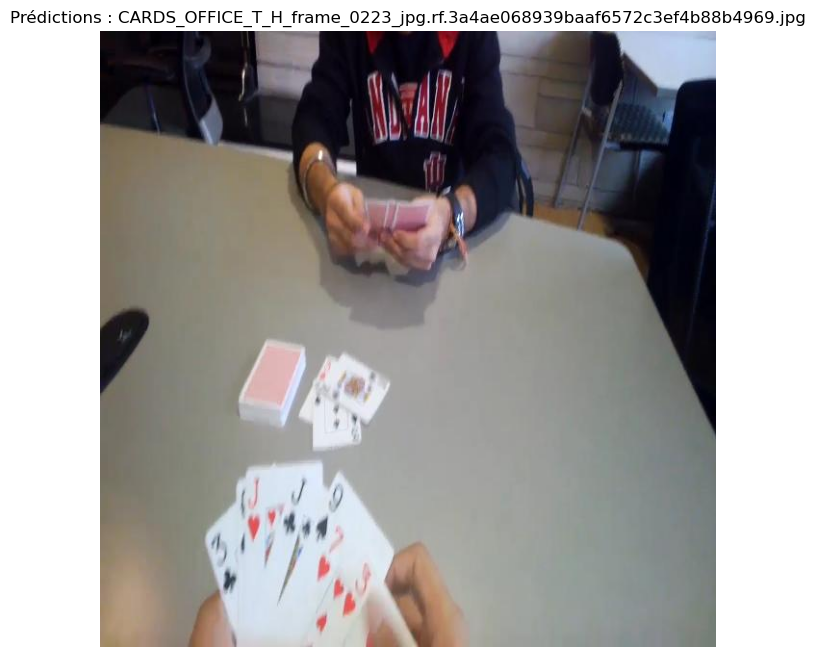

In [23]:
# Boucle sur les images et affichage des prédictions
for image_path in image_paths[:12]:
    results = model(image_path)  # prédiction YOLO
    result_image = results[0].plot()  # image avec les boxes
    
    # Affichage avec matplotlib
    plt.figure(figsize=(10, 8))
    plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))
    plt.title(f"Prédictions : {os.path.basename(image_path)}")
    plt.axis('off')
    plt.show()

    #sauvegarde résultats prédictifs
    save_path = os.path.join("outputs", os.path.basename(image_path))
    os.makedirs("outputs", exist_ok=True)
    cv2.imwrite(save_path, result_image)